In [1]:
import numpy as np
import pandas as pd 
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
import warnings 
warnings.filterwarnings("ignore")

In [2]:

# Define the file path
file_path = 'Student data.csv'

# Define the column names
columns = [
    "First Term Gpa", "Second Term Gpa", "First Language", "Funding", "School",
    "Fast Track", "Coop", "Residency", "Gender", "Prev Education", "Age Group",
    "High School Average Mark", "Math Score", "English Grade", "FirstYearPersistence"
]

columns = [col.lower().replace(' ', '_') for col in columns]

# Load the CSV file, skipping the first 25 rows
df = pd.read_csv(file_path, skiprows=25, header=None)

# Set the column names
df.columns = columns



Listing the categorical and numerical variable from the dataset description. 

In [3]:
categorical_variables = [
    "first_language",
    "funding",
    "school",
    "fast_track",
    "coop",
    "residency",
    "gender",
    "prev_education",
    "age_group",
    "english_grade",
]

numerical_variables = [
    "first_term_gpa",
    "second_term_gpa",
    "high_school_average_mark",
    "math_score"
]


#### Categorical variables analysis: 

In [4]:
# list all the categorial variables with "?" in them.
missing_cat = [] # categorical columns with missing values.
for cat in categorical_variables:  
    val_c = df[cat].value_counts()
    if "?" in val_c.index:
        missing_cat.append(cat)
    
print(f"Categorical Columns with '?' in them: {missing_cat}")

Categorical Columns with '?' in them: ['first_language', 'prev_education', 'age_group', 'english_grade']


Let's dive deeper into each of the variables. 

**first_language**

In [5]:
v_c = df["first_language"].value_counts().reset_index()
v_c

,first_language,count
0,1,719
1,3,602
2,?,111
3,2,4


Since first language has 3 possible values : 1 = English, 2 = French 2, 3 = Other This is not missing at random. 

**prev_education**

In [6]:
v_c = df["prev_education"].value_counts().reset_index()
v_c

,prev_education,count
0,1,862
1,2,482
2,0,88
3,?,4


**age_group**

In [7]:
v_c = df["age_group"].value_counts().reset_index()
v_c

,age_group,count
0,3,550
1,1,356
2,2,294
3,4,115
4,5,41
5,7,37
6,6,30
7,8,9
8,?,4


Here,  the missing age group represented by ? can be replaced by the only age group not listed on value count which is 9 (61 to 65).

In [8]:
df['age_group'] = df['age_group'].replace('?', 9)
df['age_group'] = pd.to_numeric(df['age_group'])


**english_grade**

In [9]:
v_c = df["english_grade"].value_counts().reset_index()
v_c

,english_grade,count
0,9,504
1,8,316
2,7,249
3,10,187
4,4,97
5,?,45
6,3,33
7,1,3
8,2,2


The missing value can be ambigious. It can be either 5 or 6.

Converting ? to `Nan` Value.

In [10]:
df.replace('?',np.NaN, inplace=True)

**Missingness Analysis**

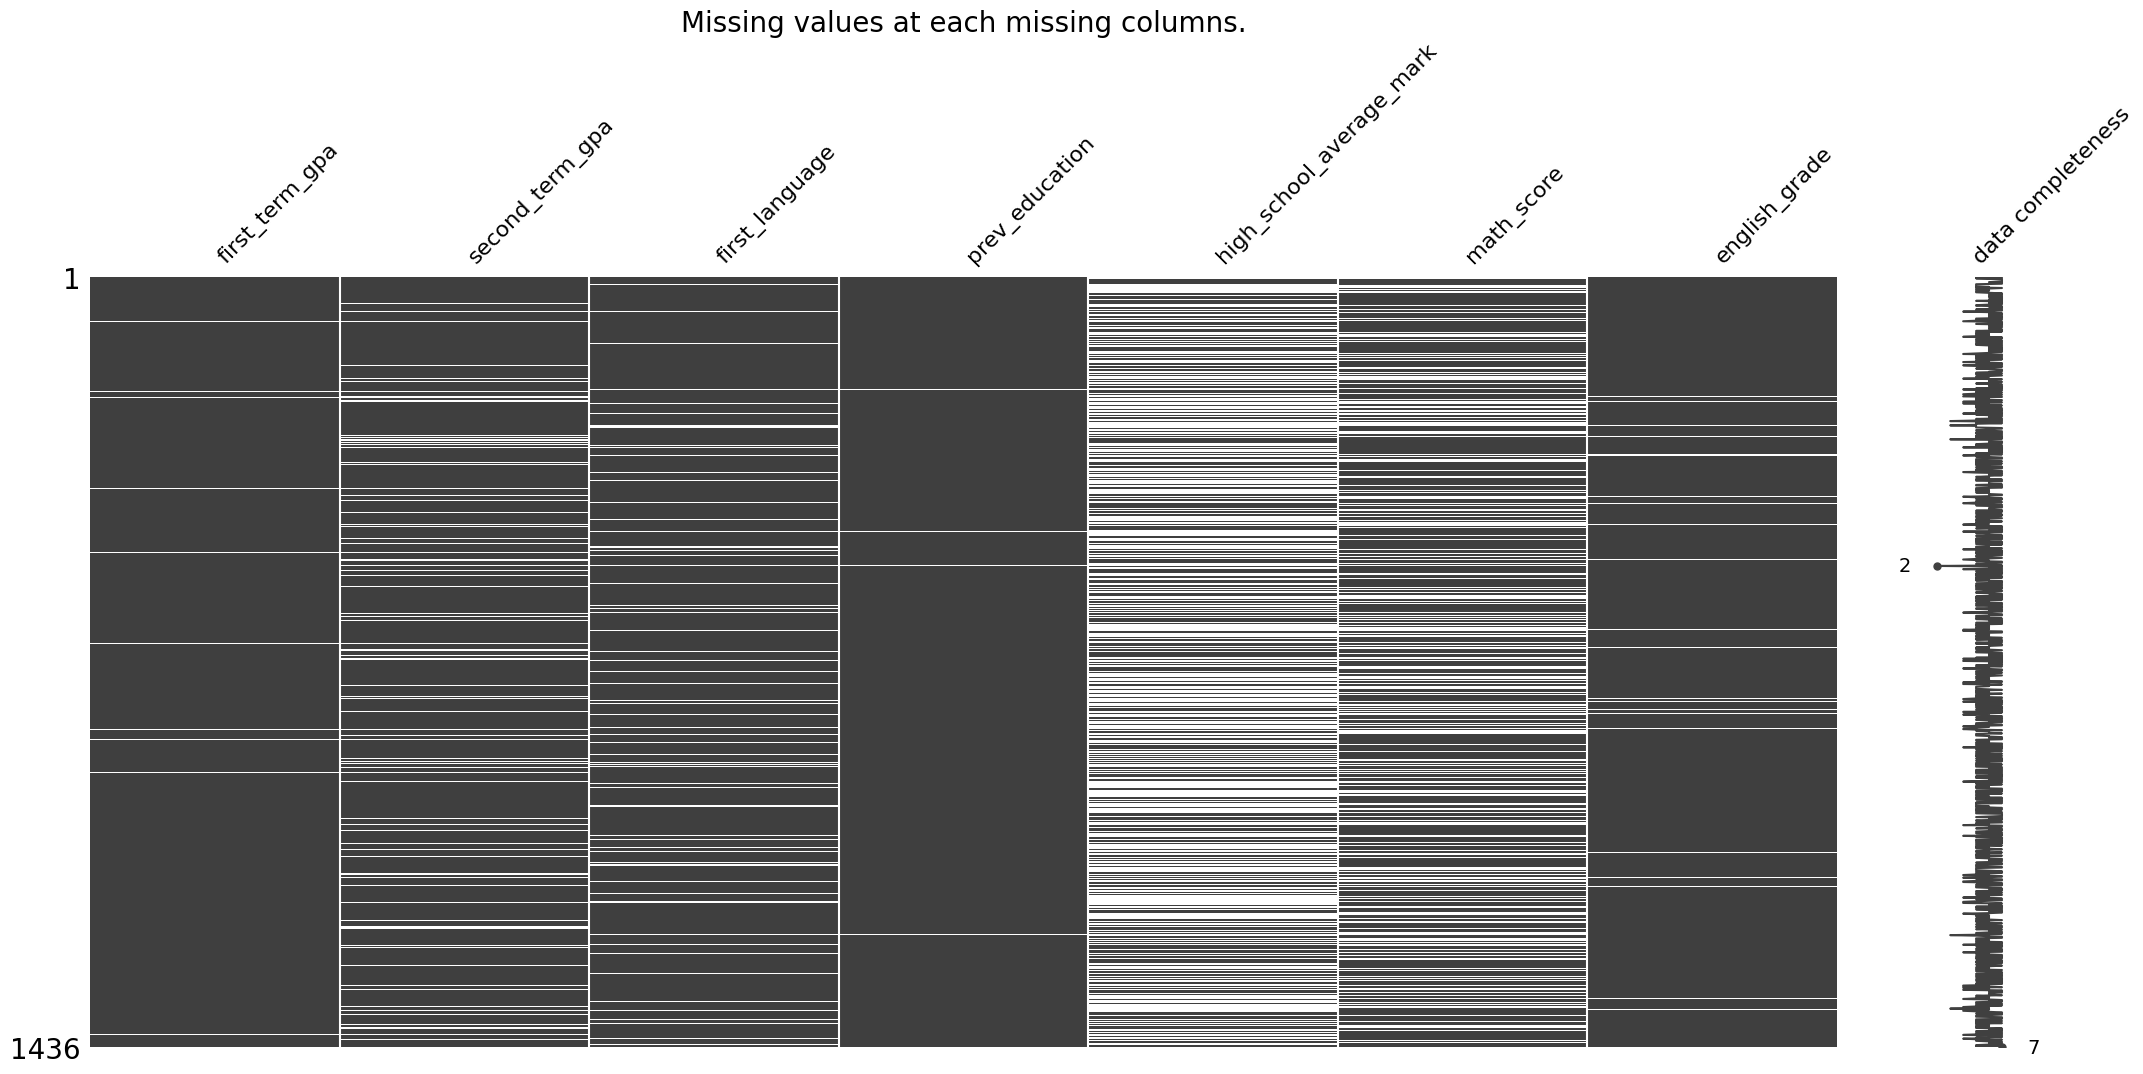

In [11]:
col_mis_val = df.columns[df.isnull().sum() > 0]
col_mis_val = col_mis_val.to_list()
msno.matrix(df[col_mis_val],labels="Missing Values ")
plt.title("Missing values at each missing columns.",fontsize=20)
plt.show()

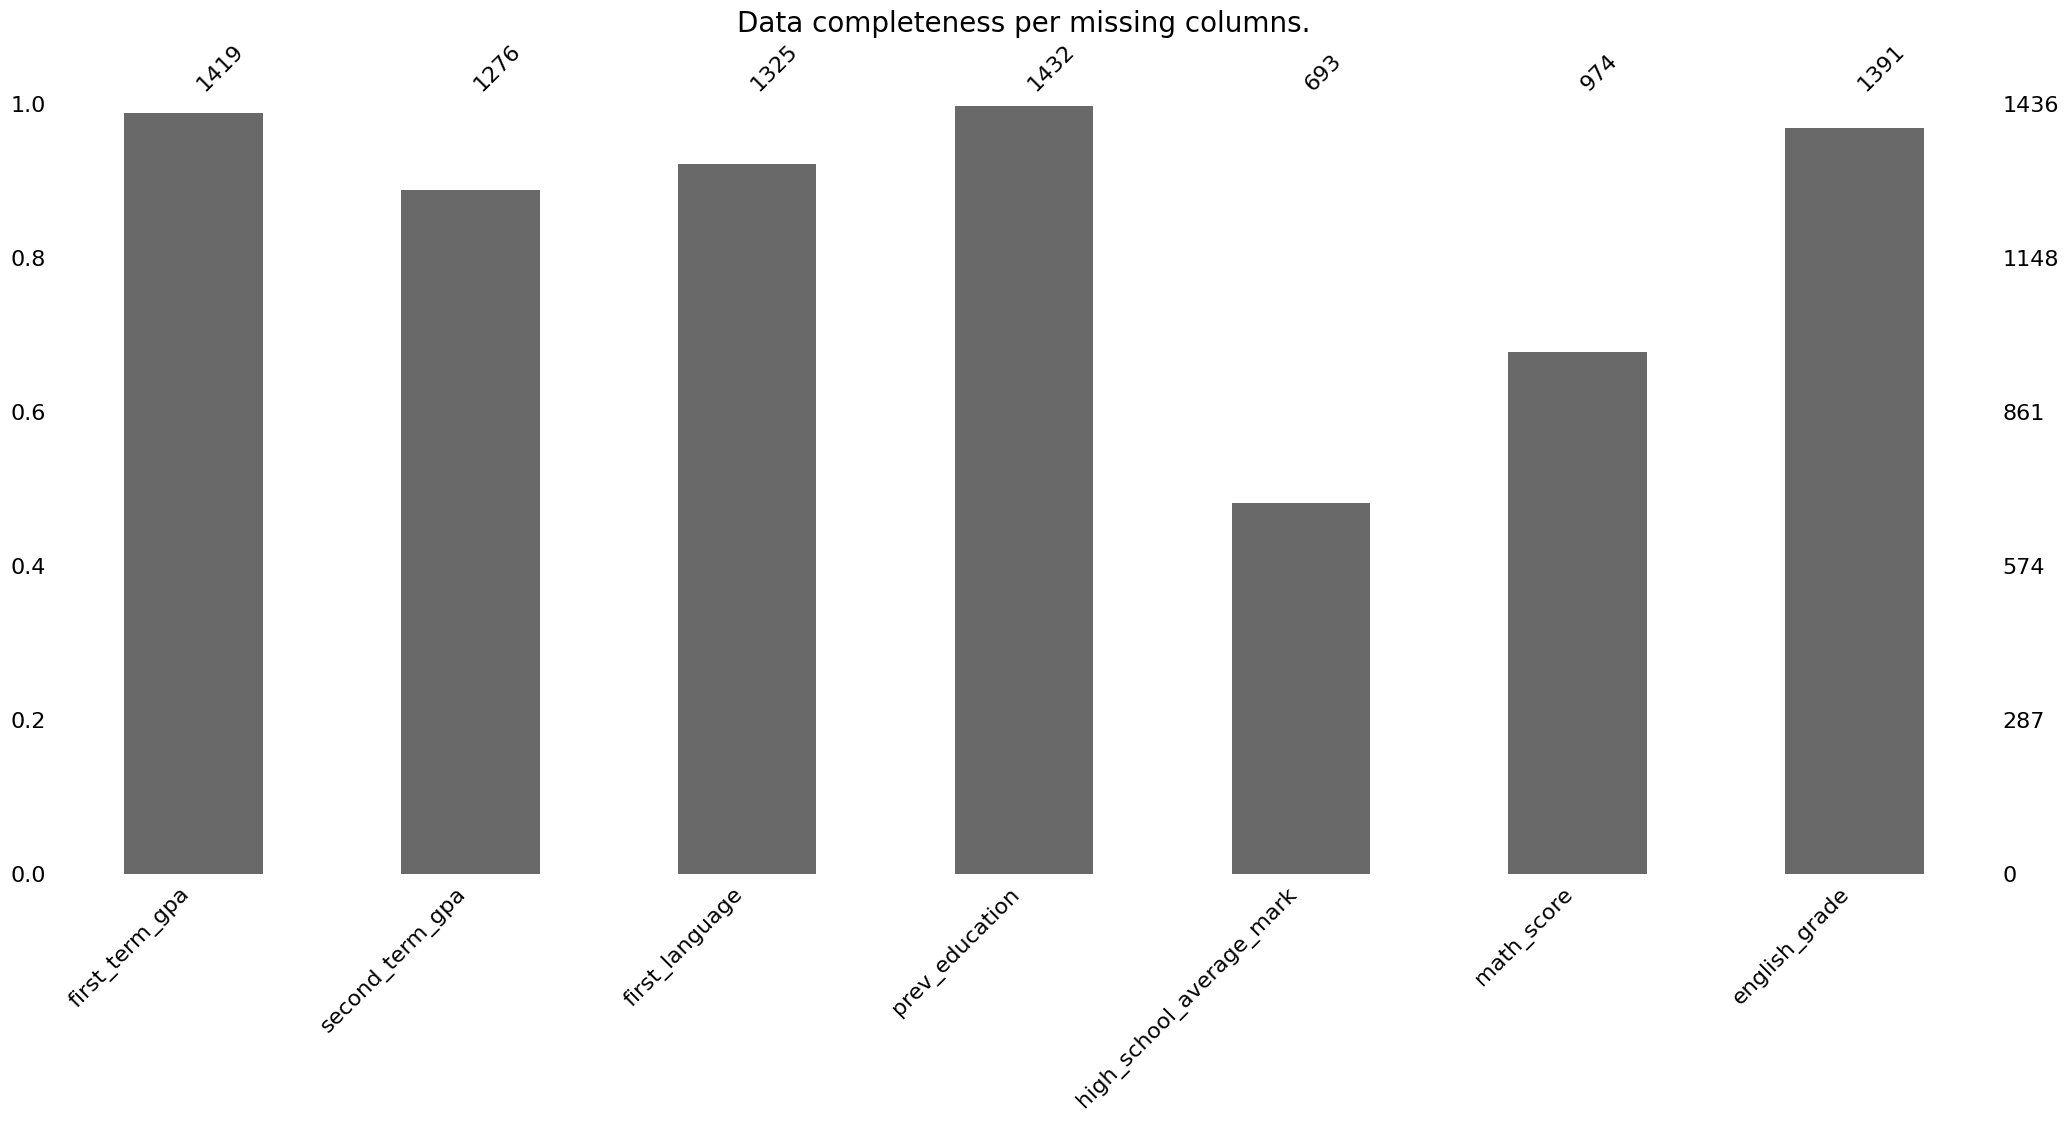

In [12]:
msno.bar(df[col_mis_val],labels="Missing Values ")
plt.title("Data completeness per missing columns.",fontsize=20)
plt.show()

#### Handelling the missing values

In [13]:
# covert all numerical to numerical 
for k in numerical_variables:
    df[str(k)] = pd.to_numeric(df[str(k)])


In [14]:
classifier_cols = categorical_variables
bool_cols = []
regressor_cols = numerical_variables

fe_df = df[classifier_cols+regressor_cols]
fe_df.head()

missing_data_cols = fe_df.isnull().sum()[fe_df.isnull().sum() > 0].index.tolist()



def impute_categorical_missing_data(passed_col):
    
    df_null = fe_df[fe_df[passed_col].isnull()]
    df_not_null = fe_df[fe_df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = fe_df[fe_df[passed_col].isnull()]
    df_not_null = fe_df[fe_df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

In [15]:
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((fe_df[col].isnull().sum() / len(fe_df)) * 100, 2))+"%")
    if col in classifier_cols:
        fe_df[col] = impute_categorical_missing_data(col)
    elif col in regressor_cols:
        fe_df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values first_language : 7.73%
The feature 'first_language' has been imputed with 90.57 accuracy

Missing Values prev_education : 0.28%
The feature 'prev_education' has been imputed with 70.03 accuracy

Missing Values english_grade : 3.13%
The feature 'english_grade' has been imputed with 51.61 accuracy

Missing Values first_term_gpa : 1.18%
MAE = 0.4978162107183098 

Missing Values second_term_gpa : 11.14%
MAE = 0.5152995469083892 

Missing Values high_school_average_mark : 51.74%
MAE = 7.632877697841725 

Missing Values math_score : 32.17%
MAE = 5.866361111111112 



Lets look at the missiness now:

In [16]:
fe_df.isnull().sum()

first_language              0
funding                     0
school                      0
fast_track                  0
coop                        0
residency                   0
gender                      0
prev_education              0
age_group                   0
english_grade               0
first_term_gpa              0
second_term_gpa             0
high_school_average_mark    0
math_score                  0
dtype: int64

## TEST

**Feature Engineering**

In [17]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder

# lets divide our categorical columns into nominal and ordinal 

nominal_variables = [
    "first_language",
    "funding",
    "school",
    "fast_track",
    "coop",
    "residency",
    "gender",
    "prev_education"
]

ordinal_variables = [
    "age_group",
    "english_grade"
]

numerical_variables = [
    "first_term_gpa",
    "second_term_gpa",
    "high_school_average_mark",
    "math_score"
]


##################### One-hot encoding to Nominal ##############################################
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
one_hot_encoded = pd.DataFrame(one_hot_encoder.fit_transform(fe_df[nominal_variables]), 
                               columns=one_hot_encoder.get_feature_names_out(nominal_variables))

########################## Ordinal Encoding for ordinal variables ###############################
label_encoders = {}
for var in ordinal_variables:
    le = LabelEncoder()
    fe_df[var] = le.fit_transform(fe_df[var])
    label_encoders[var] = le

########################### Min-Max Scaling for numerical variables ##############################
scaler = MinMaxScaler()
scaled_numerical = pd.DataFrame(scaler.fit_transform(fe_df[numerical_variables]), 
                                columns=numerical_variables)

# Combine all processed features and also add the target feature.
processed_data = pd.concat([scaled_numerical, fe_df[ordinal_variables], 
                            one_hot_encoded, df['firstyearpersistence']], axis=1)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data into features and target variable
X = processed_data.drop('firstyearpersistence', axis=1).values
y = processed_data['firstyearpersistence'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y.view(-1, 1)  # Reshape y to have shape [num_samples, 1]
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create the custom datasets
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

# Create the DataLoaders
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model, loss function, and optimizer
model = NeuralNetwork(X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the EarlyStopping class
class EarlyStopping:
    def __init__(self, min_delta=0.001, patience=20, restore_best_weights=True):
        self.min_delta = min_delta
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')
        self.counter = 0
        self.best_model = None

    def __call__(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

In [19]:
# Initialize lists to store training and testing loss and accuracy
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Train the model
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()
    
    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Evaluate on the validation set
    model.eval()
    val_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_test += batch_y.size(0)
            correct_test += (predicted == batch_y).sum().item()
    
    val_loss /= len(test_loader)
    test_accuracy = correct_test / total_test
    test_losses.append(val_loss)
    test_accuracies.append(test_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {val_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    # Check early stopping
    if early_stopping(val_loss):
        print("Early stopping triggered")
        break


Epoch [1/50], Train Loss: 0.5473, Train Accuracy: 0.7805, Test Loss: 0.4599, Test Accuracy: 0.8194
Epoch [2/50], Train Loss: 0.4817, Train Accuracy: 0.7848, Test Loss: 0.4267, Test Accuracy: 0.8194
Epoch [3/50], Train Loss: 0.4510, Train Accuracy: 0.7848, Test Loss: 0.3723, Test Accuracy: 0.8194
Epoch [4/50], Train Loss: 0.4264, Train Accuracy: 0.7848, Test Loss: 0.3608, Test Accuracy: 0.8194
Epoch [5/50], Train Loss: 0.4042, Train Accuracy: 0.8084, Test Loss: 0.3334, Test Accuracy: 0.8819
Epoch [6/50], Train Loss: 0.3803, Train Accuracy: 0.8415, Test Loss: 0.3182, Test Accuracy: 0.8750
Epoch [7/50], Train Loss: 0.3685, Train Accuracy: 0.8449, Test Loss: 0.3176, Test Accuracy: 0.8854
Epoch [8/50], Train Loss: 0.3599, Train Accuracy: 0.8589, Test Loss: 0.3801, Test Accuracy: 0.8229
Epoch [9/50], Train Loss: 0.3597, Train Accuracy: 0.8563, Test Loss: 0.3120, Test Accuracy: 0.8819
Epoch [10/50], Train Loss: 0.3556, Train Accuracy: 0.8598, Test Loss: 0.3107, Test Accuracy: 0.8750
Epoch [11

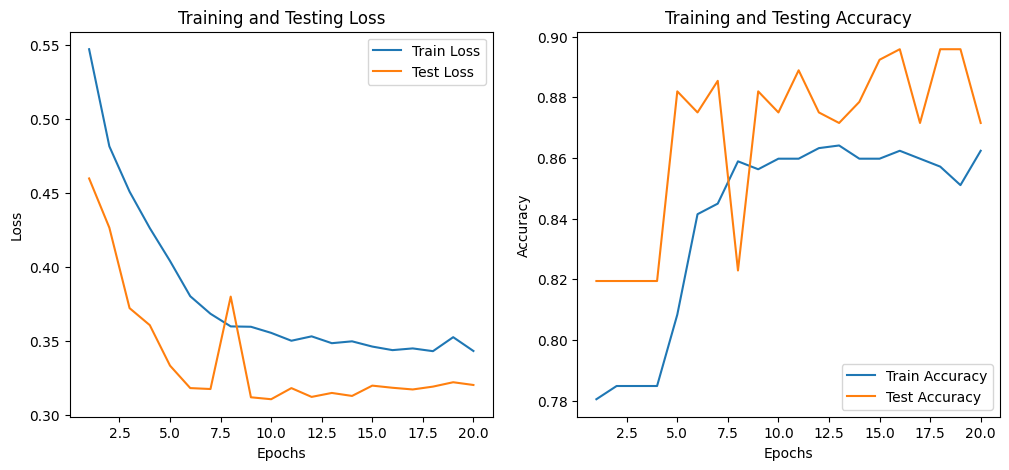

In [20]:
# Plot the training and testing loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot losses
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
ax1.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Testing Loss')
ax1.legend()

# Plot accuracies
ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
ax2.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Testing Accuracy')
ax2.legend()

plt.show()

Confusion Matrix:
[[ 24  28]
 [  9 227]]


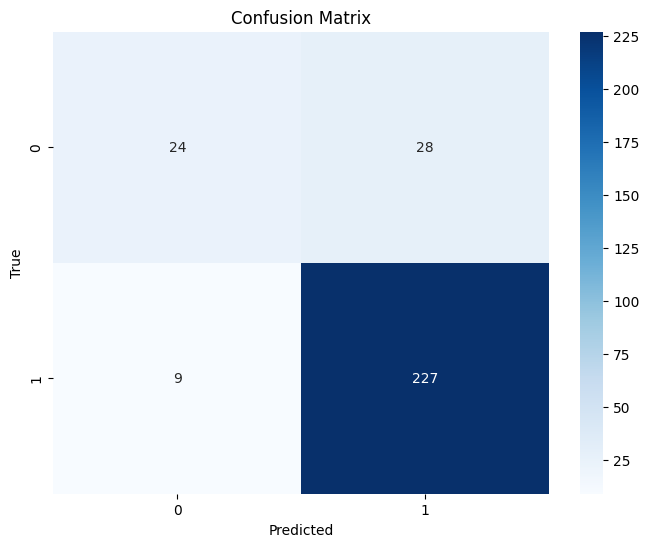

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.73      0.46      0.56        52
     Class 1       0.89      0.96      0.92       236

    accuracy                           0.87       288
   macro avg       0.81      0.71      0.74       288
weighted avg       0.86      0.87      0.86       288



In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        predicted = (outputs > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(batch_y.numpy())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)


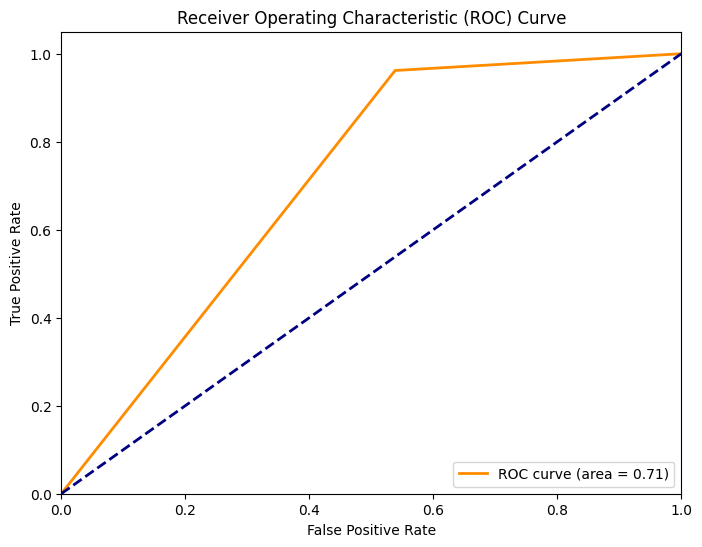

In [23]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()